In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,1449601855,1.001354,0.065186,-0.096520,0.165298,1.000807,1.002259,1.003631,0.837790,6.682252,...,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2


# Interpolating acceleration columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, int(hidden_dim/2)),
            generator_block(int(hidden_dim/2), int(hidden_dim/4)),
            generator_block(int(hidden_dim/4), 30),
            generator_block(30, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    wasser_dim = []
    latent_vectors = get_noise(len(sample), z_dim)
    fake_features = gen(latent_vectors)
    for k in range(feature_dim):
        wasser_dim.append(wasserstein_distance(fake_features[:, k].detach().numpy(), sample[:, k].detach().numpy()))
    return torch.tensor(wasser_dim)

# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "Test Gan"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 1000

# Number of dimensions of output from generator
feature_dim = 26

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 1000

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = False # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 50        # Epoch number to change training epoch ratio
disc_epochs_change = 1      # New number of consecutive epochs to train discriminator
gen_epochs_change = 50      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 18   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 4  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.4    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.6    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.85

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            to_train = DISCRIMINATOR
            train_string = "DISC"
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, batch_size, batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), batch_size, z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, batch_size, z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/1000] Training: DISC | Loss D: 0.71103, Loss G: 0.52252 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [2/1000] Training: DISC | Loss D: 0.71216, Loss G: 0.52246 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [3/1000] Training: DISC | Loss D: 0.71174, Loss G: 0.52289 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [4/1000] Training: DISC | Loss D: 0.70994, Loss G: 0.52273 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [5/1000] Training: GEN | Loss D: 0.71033, Loss G: 0.52292 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [6/1000] Training: GEN | Loss D: 0.71059, Loss G: 0.52299 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [7/1000] Training: DISC | Loss D: 0.71036, Loss G: 0.52302 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [8/1000] Trainin

Epoch [59/1000] Training: DISC | Loss D: 0.70289, Loss G: 0.54242 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [60/1000] Training: DISC | Loss D: 0.70150, Loss G: 0.54217 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [61/1000] Training: DISC | Loss D: 0.69999, Loss G: 0.54374 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [62/1000] Training: DISC | Loss D: 0.70117, Loss G: 0.54323 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [63/1000] Training: DISC | Loss D: 0.70008, Loss G: 0.54488 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [64/1000] Training: DISC | Loss D: 0.70061, Loss G: 0.54407 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [65/1000] Training: DISC | Loss D: 0.70097, Loss G: 0.54509 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [66/100

Epoch [116/1000] Training: DISC | Loss D: 0.68164, Loss G: 0.57447 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [117/1000] Training: DISC | Loss D: 0.68161, Loss G: 0.57599 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [118/1000] Training: DISC | Loss D: 0.68194, Loss G: 0.57564 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [119/1000] Training: DISC | Loss D: 0.68337, Loss G: 0.57664 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [120/1000] Training: DISC | Loss D: 0.68271, Loss G: 0.57711 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [121/1000] Training: DISC | Loss D: 0.67902, Loss G: 0.57811 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch [122/1000] Training: DISC | Loss D: 0.68574, Loss G: 0.57801 | Accuracy: 0.33599 | fpR: 1.00000 | P: 0.33599 | R: 1.00000 | F1: 0.50261
Epoch 

Epoch [175/1000] Training: DISC | Loss D: 0.65183, Loss G: 0.62043 | Accuracy: 0.34661 | fpR: 0.98400 | P: 0.33960 | R: 1.00000 | F1: 0.50664
Epoch [176/1000] Training: DISC | Loss D: 0.65408, Loss G: 0.62209 | Accuracy: 0.35857 | fpR: 0.96600 | P: 0.34375 | R: 1.00000 | F1: 0.51125
Epoch [177/1000] Training: DISC | Loss D: 0.65490, Loss G: 0.62425 | Accuracy: 0.35193 | fpR: 0.97600 | P: 0.34143 | R: 1.00000 | F1: 0.50868
Epoch [178/1000] Training: DISC | Loss D: 0.65075, Loss G: 0.62559 | Accuracy: 0.35458 | fpR: 0.97200 | P: 0.34235 | R: 1.00000 | F1: 0.50970
Epoch [179/1000] Training: DISC | Loss D: 0.65073, Loss G: 0.62515 | Accuracy: 0.35724 | fpR: 0.96800 | P: 0.34328 | R: 1.00000 | F1: 0.51073
Epoch [180/1000] Training: DISC | Loss D: 0.65672, Loss G: 0.62744 | Accuracy: 0.35458 | fpR: 0.97200 | P: 0.34235 | R: 1.00000 | F1: 0.50970
Epoch [181/1000] Training: DISC | Loss D: 0.65086, Loss G: 0.62941 | Accuracy: 0.37583 | fpR: 0.94000 | P: 0.34993 | R: 1.00000 | F1: 0.51806
Epoch 

Epoch [233/1000] Training: DISC | Loss D: 0.60817, Loss G: 0.69537 | Accuracy: 0.71713 | fpR: 0.42200 | P: 0.54329 | R: 0.99209 | F1: 0.70164
Epoch [234/1000] Training: DISC | Loss D: 0.60729, Loss G: 0.69778 | Accuracy: 0.72643 | fpR: 0.40600 | P: 0.55188 | R: 0.98814 | F1: 0.70776
Epoch [235/1000] Training: DISC | Loss D: 0.60554, Loss G: 0.69786 | Accuracy: 0.71846 | fpR: 0.41600 | P: 0.54486 | R: 0.98419 | F1: 0.70095
Epoch [236/1000] Training: DISC | Loss D: 0.60356, Loss G: 0.70399 | Accuracy: 0.74369 | fpR: 0.37600 | P: 0.56881 | R: 0.98024 | F1: 0.71942

Pull Generator

Epoch [237/1000] Training: GEN | Loss D: 0.60655, Loss G: 0.70327 | Accuracy: 0.73174 | fpR: 0.39800 | P: 0.55679 | R: 0.98814 | F1: 0.71179

Pull Generator

Epoch [238/1000] Training: GEN | Loss D: 0.60666, Loss G: 0.69830 | Accuracy: 0.71713 | fpR: 0.42200 | P: 0.54329 | R: 0.99209 | F1: 0.70164
Epoch [239/1000] Training: DISC | Loss D: 0.61328, Loss G: 0.69990 | Accuracy: 0.71580 | fpR: 0.41000 | P: 0.54343 |

Epoch [288/1000] Training: DISC | Loss D: 0.60745, Loss G: 0.69660 | Accuracy: 0.69057 | fpR: 0.44000 | P: 0.52174 | R: 0.94862 | F1: 0.67275
Epoch [289/1000] Training: DISC | Loss D: 0.60519, Loss G: 0.69699 | Accuracy: 0.69323 | fpR: 0.44600 | P: 0.52350 | R: 0.96838 | F1: 0.67916
Epoch [290/1000] Training: DISC | Loss D: 0.60224, Loss G: 0.70528 | Accuracy: 0.70916 | fpR: 0.41400 | P: 0.53795 | R: 0.95257 | F1: 0.68713
Epoch [291/1000] Training: DISC | Loss D: 0.60624, Loss G: 0.70320 | Accuracy: 0.71448 | fpR: 0.40800 | P: 0.54260 | R: 0.95652 | F1: 0.69196
Epoch [292/1000] Training: DISC | Loss D: 0.59450, Loss G: 0.70507 | Accuracy: 0.73174 | fpR: 0.39200 | P: 0.55756 | R: 0.97628 | F1: 0.70931

Pull Generator

Epoch [293/1000] Training: GEN | Loss D: 0.60859, Loss G: 0.70349 | Accuracy: 0.69057 | fpR: 0.44400 | P: 0.52155 | R: 0.95652 | F1: 0.67458
Epoch [294/1000] Training: DISC | Loss D: 0.60169, Loss G: 0.70327 | Accuracy: 0.71580 | fpR: 0.41000 | P: 0.54343 | R: 0.96443 | F1

Epoch [344/1000] Training: DISC | Loss D: 0.59746, Loss G: 0.71135 | Accuracy: 0.71049 | fpR: 0.39800 | P: 0.54042 | R: 0.92490 | F1: 0.68175

Pull Generator

Epoch [345/1000] Training: GEN | Loss D: 0.59998, Loss G: 0.70334 | Accuracy: 0.68260 | fpR: 0.43400 | P: 0.51562 | R: 0.91304 | F1: 0.65860
Epoch [346/1000] Training: DISC | Loss D: 0.59839, Loss G: 0.70827 | Accuracy: 0.69987 | fpR: 0.42400 | P: 0.52993 | R: 0.94466 | F1: 0.67852
Epoch [347/1000] Training: DISC | Loss D: 0.60471, Loss G: 0.71221 | Accuracy: 0.70252 | fpR: 0.41200 | P: 0.53288 | R: 0.92885 | F1: 0.67677
Epoch [348/1000] Training: DISC | Loss D: 0.59975, Loss G: 0.70716 | Accuracy: 0.73572 | fpR: 0.37200 | P: 0.56338 | R: 0.94862 | F1: 0.70645

Pull Generator

Epoch [349/1000] Training: GEN | Loss D: 0.60491, Loss G: 0.70354 | Accuracy: 0.69588 | fpR: 0.42600 | P: 0.52667 | R: 0.93676 | F1: 0.67379
Epoch [350/1000] Training: DISC | Loss D: 0.59670, Loss G: 0.70857 | Accuracy: 0.71713 | fpR: 0.39600 | P: 0.54587 |

Epoch [401/1000] Training: DISC | Loss D: 0.59229, Loss G: 0.72089 | Accuracy: 0.74768 | fpR: 0.35200 | P: 0.57590 | R: 0.94466 | F1: 0.71510

Pull Generator

Epoch [402/1000] Training: GEN | Loss D: 0.60665, Loss G: 0.71376 | Accuracy: 0.69323 | fpR: 0.43400 | P: 0.52412 | R: 0.94466 | F1: 0.67373
Epoch [403/1000] Training: DISC | Loss D: 0.59652, Loss G: 0.71147 | Accuracy: 0.72643 | fpR: 0.37800 | P: 0.55529 | R: 0.93281 | F1: 0.69570

Pull Generator

Epoch [404/1000] Training: GEN | Loss D: 0.59684, Loss G: 0.71465 | Accuracy: 0.69987 | fpR: 0.40200 | P: 0.53147 | R: 0.90119 | F1: 0.66816
Epoch [405/1000] Training: DISC | Loss D: 0.60187, Loss G: 0.71102 | Accuracy: 0.70784 | fpR: 0.40000 | P: 0.53811 | R: 0.92095 | F1: 0.67884

Pull Generator

Epoch [406/1000] Training: GEN | Loss D: 0.60468, Loss G: 0.70912 | Accuracy: 0.68526 | fpR: 0.42800 | P: 0.51802 | R: 0.90909 | F1: 0.65951
Epoch [407/1000] Training: DISC | Loss D: 0.60404, Loss G: 0.70760 | Accuracy: 0.69456 | fpR: 0.4220

Epoch [457/1000] Training: GEN | Loss D: 0.59200, Loss G: 0.70987 | Accuracy: 0.69721 | fpR: 0.42000 | P: 0.52809 | R: 0.92885 | F1: 0.67289
Epoch [458/1000] Training: DISC | Loss D: 0.60465, Loss G: 0.70737 | Accuracy: 0.71580 | fpR: 0.39800 | P: 0.54462 | R: 0.94071 | F1: 0.68939

Pull Generator

Epoch [459/1000] Training: GEN | Loss D: 0.61185, Loss G: 0.70703 | Accuracy: 0.70651 | fpR: 0.41800 | P: 0.53556 | R: 0.95257 | F1: 0.68517
Epoch [460/1000] Training: DISC | Loss D: 0.60528, Loss G: 0.70953 | Accuracy: 0.69721 | fpR: 0.42400 | P: 0.52784 | R: 0.93676 | F1: 0.67475
Epoch [461/1000] Training: DISC | Loss D: 0.59913, Loss G: 0.71227 | Accuracy: 0.68260 | fpR: 0.43400 | P: 0.51562 | R: 0.91304 | F1: 0.65860
Epoch [462/1000] Training: DISC | Loss D: 0.60630, Loss G: 0.70615 | Accuracy: 0.71713 | fpR: 0.39400 | P: 0.54608 | R: 0.93676 | F1: 0.68949

Pull Generator

Epoch [463/1000] Training: GEN | Loss D: 0.60367, Loss G: 0.70709 | Accuracy: 0.67995 | fpR: 0.43000 | P: 0.51357 | 

Epoch [514/1000] Training: DISC | Loss D: 0.60275, Loss G: 0.73472 | Accuracy: 0.70252 | fpR: 0.41000 | P: 0.53303 | R: 0.92490 | F1: 0.67584
Epoch [515/1000] Training: DISC | Loss D: 0.60539, Loss G: 0.72277 | Accuracy: 0.72643 | fpR: 0.37600 | P: 0.55556 | R: 0.92885 | F1: 0.69480

Pull Generator

Epoch [516/1000] Training: GEN | Loss D: 0.59555, Loss G: 0.73101 | Accuracy: 0.70916 | fpR: 0.39000 | P: 0.54009 | R: 0.90514 | F1: 0.67605

Pull Generator

Epoch [517/1000] Training: GEN | Loss D: 0.60697, Loss G: 0.71736 | Accuracy: 0.68526 | fpR: 0.41200 | P: 0.51869 | R: 0.87747 | F1: 0.65152
Epoch [518/1000] Training: DISC | Loss D: 0.60719, Loss G: 0.72079 | Accuracy: 0.67995 | fpR: 0.43600 | P: 0.51339 | R: 0.90909 | F1: 0.65574
Epoch [519/1000] Training: DISC | Loss D: 0.60674, Loss G: 0.72136 | Accuracy: 0.70651 | fpR: 0.38800 | P: 0.53810 | R: 0.89328 | F1: 0.67115

Pull Generator

Epoch [520/1000] Training: GEN | Loss D: 0.60329, Loss G: 0.71725 | Accuracy: 0.69323 | fpR: 0.4140

Epoch [570/1000] Training: DISC | Loss D: 0.59598, Loss G: 0.71900 | Accuracy: 0.68924 | fpR: 0.40000 | P: 0.52267 | R: 0.86561 | F1: 0.65132

Pull Generator

Epoch [571/1000] Training: GEN | Loss D: 0.59690, Loss G: 0.71589 | Accuracy: 0.69057 | fpR: 0.41200 | P: 0.52315 | R: 0.89328 | F1: 0.65939
Epoch [572/1000] Training: DISC | Loss D: 0.60006, Loss G: 0.70805 | Accuracy: 0.66932 | fpR: 0.43600 | P: 0.50455 | R: 0.87747 | F1: 0.64023
Epoch [573/1000] Training: DISC | Loss D: 0.59494, Loss G: 0.71603 | Accuracy: 0.70518 | fpR: 0.40600 | P: 0.53547 | R: 0.92490 | F1: 0.67780
Epoch [574/1000] Training: DISC | Loss D: 0.58903, Loss G: 0.72328 | Accuracy: 0.66534 | fpR: 0.45000 | P: 0.50111 | R: 0.89328 | F1: 0.64159
Epoch [575/1000] Training: DISC | Loss D: 0.59298, Loss G: 0.71578 | Accuracy: 0.70120 | fpR: 0.41200 | P: 0.53182 | R: 0.92490 | F1: 0.67486
Epoch [576/1000] Training: DISC | Loss D: 0.58461, Loss G: 0.73231 | Accuracy: 0.69323 | fpR: 0.40800 | P: 0.52558 | R: 0.89328 | F1

Epoch [627/1000] Training: GEN | Loss D: 0.59418, Loss G: 0.72520 | Accuracy: 0.70120 | fpR: 0.40600 | P: 0.53226 | R: 0.91304 | F1: 0.67202
Epoch [628/1000] Training: DISC | Loss D: 0.59388, Loss G: 0.72342 | Accuracy: 0.69057 | fpR: 0.41000 | P: 0.52326 | R: 0.88933 | F1: 0.65839
Epoch [629/1000] Training: DISC | Loss D: 0.58162, Loss G: 0.73341 | Accuracy: 0.69854 | fpR: 0.41200 | P: 0.52968 | R: 0.91700 | F1: 0.67103
Epoch [630/1000] Training: DISC | Loss D: 0.58312, Loss G: 0.74382 | Accuracy: 0.71182 | fpR: 0.39600 | P: 0.54167 | R: 0.92490 | F1: 0.68275

Pull Generator

Epoch [631/1000] Training: GEN | Loss D: 0.58324, Loss G: 0.73180 | Accuracy: 0.69057 | fpR: 0.43000 | P: 0.52222 | R: 0.92885 | F1: 0.66810
Epoch [632/1000] Training: DISC | Loss D: 0.58773, Loss G: 0.74046 | Accuracy: 0.68526 | fpR: 0.43200 | P: 0.51786 | R: 0.91700 | F1: 0.66145
Epoch [633/1000] Training: DISC | Loss D: 0.58155, Loss G: 0.73832 | Accuracy: 0.68393 | fpR: 0.42200 | P: 0.51716 | R: 0.89328 | F1:

Epoch [683/1000] Training: DISC | Loss D: 0.58993, Loss G: 0.74311 | Accuracy: 0.69588 | fpR: 0.41000 | P: 0.52765 | R: 0.90514 | F1: 0.66620
Epoch [684/1000] Training: DISC | Loss D: 0.57591, Loss G: 0.73913 | Accuracy: 0.69057 | fpR: 0.40800 | P: 0.52336 | R: 0.88538 | F1: 0.65739
Epoch [685/1000] Training: DISC | Loss D: 0.57989, Loss G: 0.75161 | Accuracy: 0.70385 | fpR: 0.39600 | P: 0.53521 | R: 0.90119 | F1: 0.67111

Pull Generator

Epoch [686/1000] Training: GEN | Loss D: 0.57813, Loss G: 0.74526 | Accuracy: 0.70518 | fpR: 0.39400 | P: 0.53647 | R: 0.90119 | F1: 0.67210

Pull Generator

Epoch [687/1000] Training: GEN | Loss D: 0.58883, Loss G: 0.73850 | Accuracy: 0.69323 | fpR: 0.40000 | P: 0.52607 | R: 0.87747 | F1: 0.65731

Pull Generator

Epoch [688/1000] Training: GEN | Loss D: 0.59168, Loss G: 0.73360 | Accuracy: 0.66135 | fpR: 0.44200 | P: 0.49773 | R: 0.86561 | F1: 0.63157
Epoch [689/1000] Training: DISC | Loss D: 0.59910, Loss G: 0.72648 | Accuracy: 0.70120 | fpR: 0.4060

Epoch [739/1000] Training: DISC | Loss D: 0.57892, Loss G: 0.74304 | Accuracy: 0.69588 | fpR: 0.40800 | P: 0.52778 | R: 0.90119 | F1: 0.66523
Epoch [740/1000] Training: DISC | Loss D: 0.58490, Loss G: 0.75351 | Accuracy: 0.72377 | fpR: 0.37200 | P: 0.55396 | R: 0.91304 | F1: 0.68908

Pull Generator

Epoch [741/1000] Training: GEN | Loss D: 0.58412, Loss G: 0.74708 | Accuracy: 0.70784 | fpR: 0.38400 | P: 0.53957 | R: 0.88933 | F1: 0.67117

Pull Generator

Epoch [742/1000] Training: GEN | Loss D: 0.58335, Loss G: 0.73817 | Accuracy: 0.70518 | fpR: 0.40600 | P: 0.53547 | R: 0.92490 | F1: 0.67780
Epoch [743/1000] Training: DISC | Loss D: 0.59122, Loss G: 0.73515 | Accuracy: 0.67729 | fpR: 0.41400 | P: 0.51179 | R: 0.85771 | F1: 0.64060
Epoch [744/1000] Training: DISC | Loss D: 0.59622, Loss G: 0.74383 | Accuracy: 0.70651 | fpR: 0.37800 | P: 0.53902 | R: 0.87352 | F1: 0.66620

Pull Generator

Epoch [745/1000] Training: GEN | Loss D: 0.59148, Loss G: 0.74411 | Accuracy: 0.72908 | fpR: 0.3460

Epoch [795/1000] Training: DISC | Loss D: 0.55657, Loss G: 0.81928 | Accuracy: 0.74635 | fpR: 0.29400 | P: 0.58708 | R: 0.82609 | F1: 0.68589
Epoch [796/1000] Training: DISC | Loss D: 0.55730, Loss G: 0.82067 | Accuracy: 0.76760 | fpR: 0.26400 | P: 0.61404 | R: 0.83004 | F1: 0.70539
Epoch [797/1000] Training: DISC | Loss D: 0.54249, Loss G: 0.82054 | Accuracy: 0.76627 | fpR: 0.25400 | P: 0.61631 | R: 0.80632 | F1: 0.69814
Epoch [798/1000] Training: DISC | Loss D: 0.55618, Loss G: 0.83485 | Accuracy: 0.76627 | fpR: 0.25200 | P: 0.61702 | R: 0.80237 | F1: 0.69710
Epoch [799/1000] Training: DISC | Loss D: 0.55328, Loss G: 0.83054 | Accuracy: 0.74369 | fpR: 0.27600 | P: 0.58929 | R: 0.78261 | F1: 0.67184
Epoch [800/1000] Training: DISC | Loss D: 0.55491, Loss G: 0.84070 | Accuracy: 0.76627 | fpR: 0.23800 | P: 0.62222 | R: 0.77470 | F1: 0.68965
Epoch [801/1000] Training: DISC | Loss D: 0.54358, Loss G: 0.84392 | Accuracy: 0.79283 | fpR: 0.22800 | P: 0.64923 | R: 0.83399 | F1: 0.72961
Epoch 

Epoch [852/1000] Training: GEN | Loss D: 0.48747, Loss G: 0.93727 | Accuracy: 0.83267 | fpR: 0.16400 | P: 0.71821 | R: 0.82609 | F1: 0.76789
Epoch [853/1000] Training: DISC | Loss D: 0.48779, Loss G: 0.93154 | Accuracy: 0.84329 | fpR: 0.18000 | P: 0.71429 | R: 0.88933 | F1: 0.79176

Pull Generator

Epoch [854/1000] Training: GEN | Loss D: 0.49215, Loss G: 0.92004 | Accuracy: 0.82736 | fpR: 0.18200 | P: 0.70164 | R: 0.84585 | F1: 0.76653
Epoch [855/1000] Training: DISC | Loss D: 0.49934, Loss G: 0.92917 | Accuracy: 0.79283 | fpR: 0.18200 | P: 0.67384 | R: 0.74308 | F1: 0.70627
Epoch [856/1000] Training: DISC | Loss D: 0.51026, Loss G: 0.93504 | Accuracy: 0.83267 | fpR: 0.15800 | P: 0.72281 | R: 0.81423 | F1: 0.76530
Epoch [857/1000] Training: DISC | Loss D: 0.49976, Loss G: 0.94068 | Accuracy: 0.83134 | fpR: 0.17400 | P: 0.71000 | R: 0.84190 | F1: 0.76985
Epoch [858/1000] Training: DISC | Loss D: 0.49321, Loss G: 0.95165 | Accuracy: 0.83533 | fpR: 0.17200 | P: 0.71429 | R: 0.84980 | F1:

Epoch [910/1000] Training: DISC | Loss D: 0.44258, Loss G: 1.05291 | Accuracy: 0.84728 | fpR: 0.15800 | P: 0.73311 | R: 0.85771 | F1: 0.79003

Pull Generator

Epoch [911/1000] Training: GEN | Loss D: 0.45457, Loss G: 1.03716 | Accuracy: 0.84595 | fpR: 0.16000 | P: 0.73064 | R: 0.85771 | F1: 0.78859

Pull Generator

Epoch [912/1000] Training: GEN | Loss D: 0.45908, Loss G: 1.00975 | Accuracy: 0.84329 | fpR: 0.17400 | P: 0.71845 | R: 0.87747 | F1: 0.78954

Pull Generator

Epoch [913/1000] Training: GEN | Loss D: 0.45647, Loss G: 0.98959 | Accuracy: 0.84728 | fpR: 0.15200 | P: 0.73793 | R: 0.84585 | F1: 0.78772
Epoch [914/1000] Training: DISC | Loss D: 0.46855, Loss G: 1.00673 | Accuracy: 0.82736 | fpR: 0.17800 | P: 0.70432 | R: 0.83794 | F1: 0.76485
Epoch [915/1000] Training: DISC | Loss D: 0.47775, Loss G: 1.00335 | Accuracy: 0.83400 | fpR: 0.15600 | P: 0.72535 | R: 0.81423 | F1: 0.76673
Epoch [916/1000] Training: DISC | Loss D: 0.47284, Loss G: 1.00102 | Accuracy: 0.79548 | fpR: 0.2020

Epoch [967/1000] Training: DISC | Loss D: 0.42813, Loss G: 1.12331 | Accuracy: 0.83400 | fpR: 0.15800 | P: 0.72378 | R: 0.81818 | F1: 0.76759
Epoch [968/1000] Training: DISC | Loss D: 0.43219, Loss G: 1.11645 | Accuracy: 0.86056 | fpR: 0.11800 | P: 0.77820 | R: 0.81818 | F1: 0.79719
Epoch [969/1000] Training: DISC | Loss D: 0.41785, Loss G: 1.13241 | Accuracy: 0.85259 | fpR: 0.13400 | P: 0.75725 | R: 0.82609 | F1: 0.78967
Epoch [970/1000] Training: DISC | Loss D: 0.43466, Loss G: 1.14556 | Accuracy: 0.84993 | fpR: 0.12200 | P: 0.76718 | R: 0.79447 | F1: 0.78008
Epoch [971/1000] Training: DISC | Loss D: 0.41208, Loss G: 1.13192 | Accuracy: 0.86720 | fpR: 0.12600 | P: 0.77419 | R: 0.85375 | F1: 0.81153

Pull Generator

Epoch [972/1000] Training: GEN | Loss D: 0.42019, Loss G: 1.12993 | Accuracy: 0.82603 | fpR: 0.16000 | P: 0.71631 | R: 0.79842 | F1: 0.75464
Epoch [973/1000] Training: DISC | Loss D: 0.41101, Loss G: 1.10596 | Accuracy: 0.84861 | fpR: 0.14600 | P: 0.74386 | R: 0.83794 | F1

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
#torch.save(gen.state_dict(), "../saved_models/test_gan")
#torch.save(disc.state_dict(), "../saved_models/test_disc")

# Visualizing Generation Quality

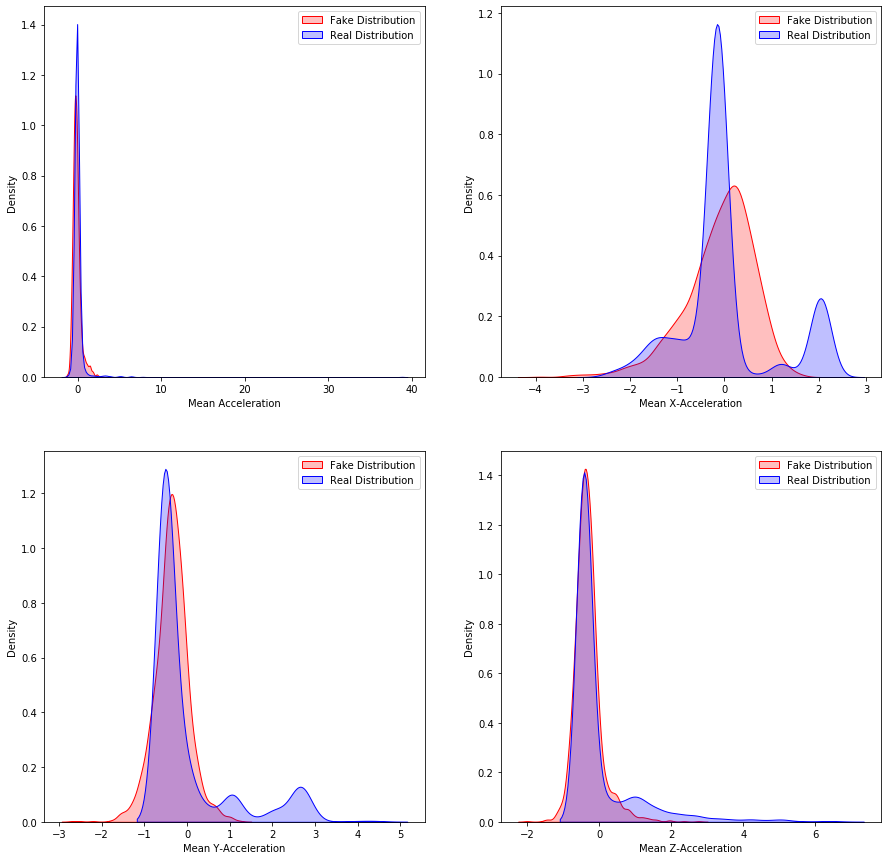

In [10]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)

In [11]:
model_output = pd.read_csv('../model_outputs/Test Gan.csv')
model_output.head()

def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

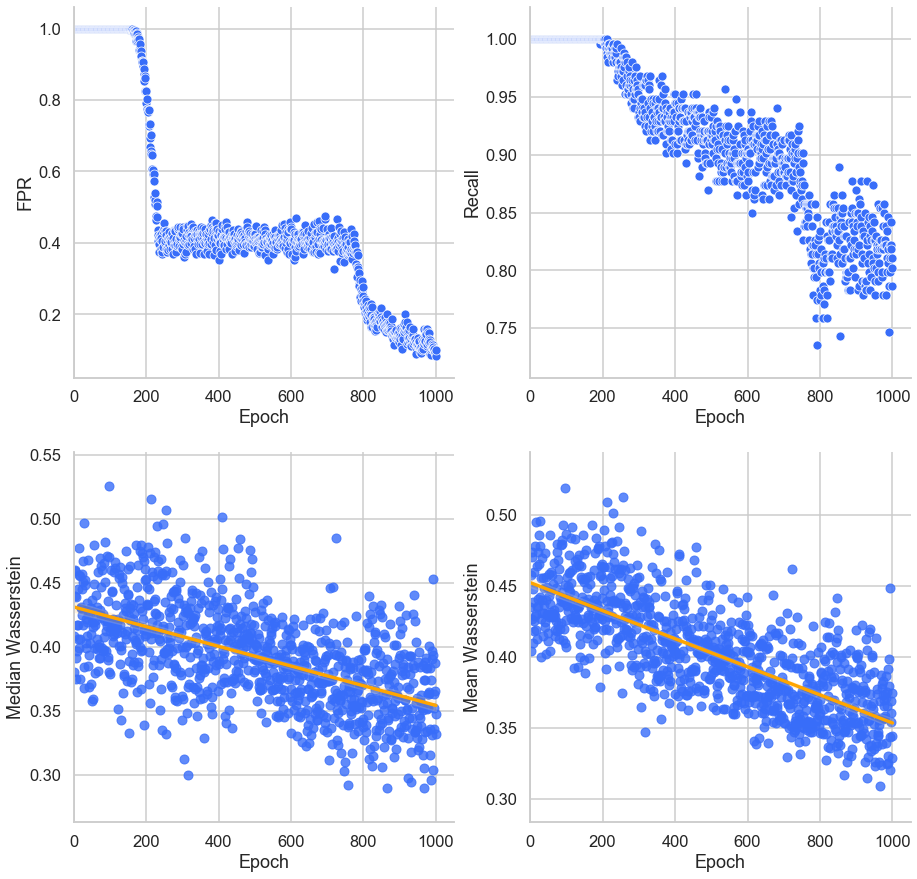

In [12]:
plot_metrics(model_output, True)